https://s3.amazonaws.com/amazon-reviews-pds/readme.html

```

DATA COLUMNS:
marketplace       - 2 letter country code of the marketplace where the review was written.
customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
review_id         - The unique ID of the review.
product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews
                    for the same product in different countries can be grouped by the same product_id.
product_parent    - Random identifier that can be used to aggregate reviews for the same product.
product_title     - Title of the product.
product_category  - Broad product category that can be used to group reviews 
                    (also used to group the dataset into coherent parts).
star_rating       - The 1-5 star rating of the review.
helpful_votes     - Number of helpful votes.
total_votes       - Number of total votes the review received.
vine              - Review was written as part of the Vine program.
verified_purchase - The review is on a verified purchase.
review_headline   - The title of the review.
review_body       - The review text.
review_date       - The date the review was written.
```

In [1]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv('amazon_reviews_us_Grocery_v1_00.tsv', 
                 nrows=40000, sep='\t', error_bad_lines=False)

df = df.drop(['marketplace', 'product_category'], axis=1)

df = df[~df['review_body'].isnull()]

df['review_body'] = df['review_headline'] + '. ' + df['review_body']

df = df[df['review_body'].apply(len) > 40]

b'Skipping line 1925: expected 15 fields, saw 22\nSkipping line 1977: expected 15 fields, saw 22\nSkipping line 35265: expected 15 fields, saw 22\n'


In [2]:
df.head(5)

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",5,0,0,N,Y,Using these for years - love them.,Using these for years - love them.. As a famil...,2015-08-31
1,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",5,0,0,N,Y,Wonderful,"Wonderful. My favorite nut. Creamy, crunchy, ...",2015-08-31
2,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,5,0,0,N,N,Five Stars,Five Stars. This green tea tastes so good! My ...,2015-08-31
3,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,5,0,0,N,Y,Five Stars,Five Stars. I love Melissa's brand but this is...,2015-08-31
6,32778285,R1S1XSG4ZCHDGS,B00BCNSTRA,578681693,"Larabar uber, 1.42 Ounce (Pack of 15)",5,1,1,N,Y,Five Stars,"Five Stars. Love these bars, but have to watch...",2015-08-31


# repeated/manipulated reviews

In [3]:
bad_customer = []

In [4]:
#customer_count = df.groupby(['customer_id', 'review_date'])['product_id'].count().reset_index()
#customer_count.columns = ['customer_id', 'review_date', 'review_count']

#customer_count.sort_values(by='review_count')

In [5]:
bad_customer += list(customer_count['customer_id'])
lenbad_customer

NameError: name 'customer_count' is not defined

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
review_tfidf = tfidf.fit_transform(df['review_body'])

In [7]:
IDX = 0

for IDX_start in range(int(review_tfidf.shape[0]/1000) +1):
    print(IDX_start)
    
    idss = np.dot(
        review_tfidf[
            IDX_start*1000:
            (IDX_start+1)*1000
        ], 
        review_tfidf.T
    ).toarray()

    for ids in idss:
        IDX += 1
        # 
        if len(np.where(ids >= 0.99)[0])==1:
            continue
        
        # print(np.where(ids >= 0.99)[0])
        
        df.iloc[np.where(ids >= 0.99)[0]][['customer_id', 'review_id', 'star_rating', 'review_body']].sort_values(by='star_rating').to_csv('t.csv', index=None, header=None, mode='a')
        
        # bad_list.extend(list(np.where(ids >= 0.99)[0]))
        bad_customer += list(df.iloc[np.where(ids >= 0.99)[0]]['customer_id'])
        # A -> B
        # B -> A

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [8]:
 df.iloc[np.where(ids >= 0.99)[0]][
     ['customer_id', 'review_id', 'review_body']].to_csv('t.csv', index=None, header=None, mode='a')

In [9]:
len(bad_customer)

2650

In [10]:
customer_rate_mean = df.groupby(['customer_id'])['star_rating'].mean()
customer_rate_count = df['customer_id'].value_counts()

customer_rate_mean = customer_rate_mean.reset_index()
customer_rate_mean.columns = ['customer_id', 'rating']

customer_rate_count = customer_rate_count.reset_index()
customer_rate_count.columns = ['customer_id', 'count']

In [11]:
customer_df = pd.merge(customer_rate_mean, customer_rate_count, on='customer_id')
customer_df.sort_values(by='count', ascending=False)

,customer_id,rating,count
8251,17162238,4.632653,49
15292,34247947,4.906250,32
15696,35178127,4.454545,22
9824,20674418,5.000000,18
16560,37293783,5.000000,17
...,...,...,...
9496,19967776,2.000000,1
9495,19963619,1.000000,1
9494,19963378,1.000000,1
9493,19962730,5.000000,1


In [12]:
customer_df[(customer_df['count'] >= 3) & (customer_df['rating'] <=3)]

,customer_id,rating,count
1538,2530619,3.000000,3
1797,3263580,1.000000,3
1928,4020516,1.666667,3
2499,6579386,3.000000,4
3071,9927828,2.000000,3
...,...,...,...
22967,50616505,3.000000,8
23011,50680590,2.666667,3
23670,51614404,2.333333,3
24839,52940403,1.333333,3


In [13]:
bad_customer += list(customer_df[(customer_df['count'] >= 3) & (customer_df['rating'] ==1)]['customer_id'])

In [14]:
select_customer = customer_df[(customer_df['count'] >= 2) & (customer_df['rating'] <=1)]['customer_id']

df[df['customer_id'].isin(select_customer)][['customer_id','review_headline', 'review_body']].sort_values(by='customer_id')

,customer_id,review_headline,review_body
28999,145437,I happen to like the half-and-half mixture,I happen to like the half-and-half mixture. I ...
28936,145437,I happen to like the half-and-half mixture,I happen to like the half-and-half mixture. I ...
5598,661293,Didn't give desired nutritional effects.,Didn't give desired nutritional effects.. Not ...
3504,661293,Not reliable.,Not reliable.. Did not have the desired effect...
36117,1211659,I am French and this sauce is an absolute insu...,I am French and this sauce is an absolute insu...
...,...,...,...
4347,52589382,I really hate being duped. What a waste of mo...,I really hate being duped. What a waste of mo...
10000,52672134,Garbage,Garbage. Don't be fooled. This product is not...
9737,52672134,Misleading. if not outright fraud,Misleading. if not outright fraud. These are n...
19617,52789885,Not really a cookie,Not really a cookie. Kinda plastic or waxy tas...


# bag of words

In [15]:
df = df[~df['customer_id'].isin(bad_customer)]

In [16]:
import re
bad_words = ['contaminate','disease', 'disgusting', 'hospital', 'poisoning',
             'rancid', 'hazardous', 'ill', 'mold','moldy', 'mildew', 'dangerous',
              'smelly', 'stale', 'unhealthy', 'sick','expired','expiration']

In [17]:
df_bad = df[df['review_body'].apply(lambda x: bool(re.search('|'.join(bad_words), x.lower())))]

In [18]:
df_bad[df_bad['star_rating'] == 1]['customer_id'].value_counts()

47180254    2
6579386     2
25866462    2
41617771    2
21540019    2
           ..
24796305    1
27387231    1
21112065    1
51886761    1
5817935     1
Name: customer_id, Length: 652, dtype: int64

## TextBlob

The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [19]:
from textblob import TextBlob

# https://textblob.readthedocs.io/en/dev/
text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

blob = TextBlob(text)

for sentence in blob.sentences:
    # sentence.sentiment.polarity 
    # sentence.sentiment.subjectivity 
    print(sentence, sentence.sentiment.polarity, sentence.sentiment.subjectivity)
    print('')


The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact. 0.06000000000000001 0.605

Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant. -0.34166666666666673 0.7666666666666666



In [20]:
bad_comment = []

from tqdm import tqdm
for line in tqdm(df[df['star_rating'] == 1]['review_body'].iloc[:]):
    line = line.replace('<br />', '')
    
    blob = TextBlob(line)
    for sentence in blob.sentences:
        # print(sentence, sentence.sentiment.polarity, sentence.sentiment.subjectivity)
        if sentence.sentiment.polarity < -0.5 and re.search('|'.join(bad_words), line.lower()):
            bad_comment.append(line)


100%|█████████████████████████████████████████████████████████████████████████████| 2455/2455 [00:02<00:00, 927.87it/s]


In [21]:
good_comment = []

from tqdm import tqdm
for line in tqdm(df[df['star_rating'] == 5]['review_body'].iloc[:500]):
    line = line.replace('<br />', '')
    
    blob = TextBlob(line)
    for sentence in blob.sentences:
        # print(sentence, sentence.sentiment.polarity, sentence.sentiment.subjectivity)
        if sentence.sentiment.polarity > 0.5 and not re.search('|'.join(bad_words), line.lower()):
            good_comment.append(line)
        

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1000.73it/s]


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# 0 --bad
label = [0] * len(bad_comment) + [1] * len(good_comment)
text = bad_comment + good_comment

label = np.array(label) 
# text = np.array(text)

tfidf = TfidfVectorizer().fit(text)
text_tfidf = tfidf.transform(text)

In [24]:
text_tfidf 

<786x3471 sparse matrix of type '<class 'numpy.float64'>'
	with 28495 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.model_selection import train_test_split
# 744 * 0.8
train_text, test_text, train_label, test_label = train_test_split(text_tfidf, label, train_size=0.8,stratify=label)

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(train_text, train_label)

In [27]:
clf.score(test_text, test_label)

0.9810126582278481

In [28]:
def predict_food_comment(s, show=True):
    s = np.array(s).reshape(1)
    s_tfidf = tfidf.transform(s)
    if clf.predict_proba(s_tfidf)[0, 0] > 0.4:
        if show:
            print(s, 'bad')
        return 'bad'
    else:
        if show:
            print(s, 'good')
        return 'good'

In [29]:
predict_food_comment('''This is the weirdest "soup" I ever tasted.''')

['This is the weirdest "soup" I ever tasted.'] bad


'bad'

In [30]:
predict_food_comment('''My stomach hurts after I eat it once''')

['My stomach hurts after I eat it once'] bad


'bad'

In [31]:
predict_food_comment('''Very delicious, very good comment''')

['Very delicious, very good comment'] good


'good'

In [32]:
predict_food_comment('''Using these for years - love them.. As a family allergic to wheat''')

['Using these for years - love them.. As a family allergic to wheat'] good


'good'

In [33]:
import codecs
for x in df[df['star_rating'] == 1]['review_body'].iloc[:]:
    if predict_food_comment(x, show=False) == 'bad':
        with codecs.open('bad.csv', 'a',encoding = 'utf-8') as up:
            up.write(x+'\n')

# selected_reviews

In [34]:
selected_df = pd.read_csv('selected_reviews.csv', header=None)

In [35]:
selected_df_text = selected_df[0] + selected_df[1].fillna('')
selected_df_text = list(selected_df_text.apply(lambda x: x.strip()).values)

Populating the interactive namespace from numpy and matplotlib


C:\Users\hrida\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


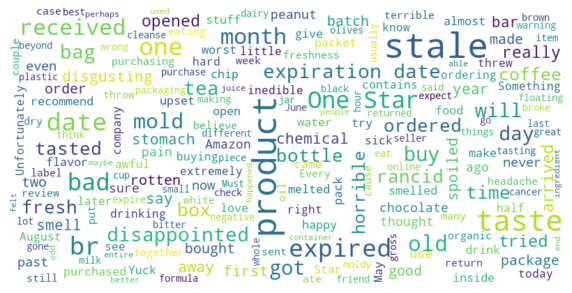

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=200, width=800, height=400,
                      background_color="white").generate(' '.join(selected_df_text))
%pylab inline

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
label = [0] * len(selected_df_text) + [0]*len(bad_comment) + [1] * len(good_comment)
text = list(selected_df_text) + bad_comment+ good_comment

label = np.array(label) 
# text = np.array(text)

tfidf = TfidfVectorizer().fit(text)
text_tfidf = tfidf.transform(text)

In [38]:
from sklearn.model_selection import train_test_split
# 744 * 0.8
train_text, test_text, train_label, test_label = train_test_split(text_tfidf, label, 
                                                train_size=0.8,stratify=label)

In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(train_text, train_label)

In [40]:
clf.score(test_text, test_label)

0.9536082474226805

In [41]:
def predict_food_comment(s, show=True):
    s = np.array(s).reshape(1)
    s_tfidf = tfidf.transform(s)

    if clf.predict_proba(s_tfidf)[0, 0] > 0.4:
        if show:
            print(s, 'bad')
        return 'bad'
    else:
        if show:
            print(s, 'good')
        return 'good'

In [42]:
predict_food_comment('''This is the weirdest "soup" I ever tasted.''')

['This is the weirdest "soup" I ever tasted.'] bad


'bad'

In [43]:
predict_food_comment('''Very delicious, very good comment''')

['Very delicious, very good comment'] good


'good'

In [45]:
import eli5
from eli5.lime import TextExplainer
from sklearn.pipeline import make_pipeline


vec = TfidfVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit(text, label)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [46]:
import eli5
eli5.show_weights(pipe, vec=vec, top=20)

In [48]:
ex = eli5.explain_weights(pipe,vec= vec,top=20)

In [50]:
df_feature_weight = eli5.formatters.as_dataframe.format_as_dataframe(ex)[['feature','weight']]

In [54]:
df_feature_weight
color=np.where(df_feature_weight['weight']<0,'red','blue')

In [55]:
import plotly.graph_objects as go


def plot_bar(xvalues, yvalues, title, xtitle, ytitle):


    fig = go.Figure()
    
    fig.add_trace(go.Bar(x=xvalues,y = yvalues,marker_color = color))

    fig.update_layout(
        xaxis_title=xtitle,
        yaxis_title=ytitle,
        title=title,
        bargap=0.1)
    
    return fig

plot_bar(xvalues=df_feature_weight['feature'],yvalues=df_feature_weight['weight'],
        title = '20 features with their corresonding affect on the predictions',
        xtitle= 'Features',
        ytitle= 'Weights')

In [52]:
eli5.show_prediction(clf, text[0], vec=vec, target_names=[0, 1])

In [53]:
eli5.show_prediction(clf, text[3], vec=vec, target_names=[0, 1])

In [54]:
eli5.show_prediction(clf, text[500], vec=vec, target_names=[0, 1])

# output

In [55]:
predict_result = pipe.predict(df['review_body'].iloc[:])

In [56]:
bad_product = df[predict_result == 0][df[predict_result == 0]['star_rating'] == 1]

In [57]:
bad_product.head()

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
9,19624355,R1ODXB3C9UP3NL,B00J074W94,2499702,"Orgain Organic Plant Based Protein Powder, Pac...",1,1,3,N,N,Disgusting now and difficult on digestion,Disgusting now and difficult on digestion. Use...,2015-08-31
17,22765168,R3T6TTD2IN0EFZ,B00XDXMLL2,971154239,"Skippy Creamy Peanut Butter, with Salted Caram...",1,4,4,N,N,"1 Out Of 5 Of My Co-Workers Thought It Was ""Okay""","1 Out Of 5 Of My Co-Workers Thought It Was ""Ok...",2015-08-31
23,35636887,R9MISLBRG08FX,B00DBSFXUA,294404974,"Keebler Town House Pita Crackers, 9.5 Ounce",1,0,0,N,Y,pita crackers,pita crackers. not craze about these. nothing ...,2015-08-31
40,29000177,R1DIYK2UJ1C7FC,B00A66TR8E,3209118,"Amoretti Premium Syrup, Pineapple, 25.4 Ounce",1,0,2,N,Y,Does not recommend!,Does not recommend!. This product is beautiful...,2015-08-31
99,33828780,R2B9WKQP7ZZVPQ,B006ONNLNA,702537450,Gustaf’s Traditional Dutch Authentic Double Sa...,1,0,5,N,Y,It's actually TOO salty.,It's actually TOO salty.. Not what I expected....,2015-08-31


In [58]:
# all
bad_product['product_id']

9        B00J074W94
17       B00XDXMLL2
23       B00DBSFXUA
40       B00A66TR8E
99       B006ONNLNA
            ...    
39933    B0097GS4II
39940    B00DY9WAZW
39955    B00V5DE4AI
39985    B00SS629VG
39987    B00L4JURMM
Name: product_id, Length: 2308, dtype: object

In [59]:
# reviews with <expied/expiration>

bad_product[
    bad_product['review_body'].apply(lambda x: 'expir' in x.lower())
][['product_id', 'product_title']]

,product_id,product_title
381,B00029KOVO,"MarketSpice Teabags, box of 24 (Market Spice T..."
1453,B00B1VPL2Y,Kellogg's Pop-Tarts Frosted Red Velvet - 8 CT
1578,B003V0IK6C,Atora Light Shredded Vegetable Suet 200gr (7.0...
2884,B00CS5T2C2,Spectrum Essentials Chia and Flax Seed Decaden...
3483,B00I08JK7S,Green Mountain Coffee Dark Magic Keurig Single...
...,...,...
39336,B00RDL7NTU,Paleo Protein Bars (20g Protein) (6 Net Carbs)...
39360,B00BJ579KO,Coco Libre Protein Coconut Water
39642,B00I709MY0,Natierra Nature's All Foods Freeze
39670,B004SK419E,"Plocky's Hummus Chips, Original, .8 oz, (Pack..."


In [60]:
bad_product[
    ~bad_product['review_body'].apply(lambda x: 'expir' in x.lower())
][['product_parent', 'product_title']]

,product_parent,product_title
9,2499702,"Orgain Organic Plant Based Protein Powder, Pac..."
17,971154239,"Skippy Creamy Peanut Butter, with Salted Caram..."
23,294404974,"Keebler Town House Pita Crackers, 9.5 Ounce"
40,3209118,"Amoretti Premium Syrup, Pineapple, 25.4 Ounce"
99,702537450,Gustaf’s Traditional Dutch Authentic Double Sa...
...,...,...
39933,636211690,Great Arrivals Sympathy Gift Basket
39940,878924470,"DRY Soda, 12 Ounce Cans (Pack of 12)"
39955,164215804,"O.N.E. Coconut Water, Wild Orange with Tea, 16..."
39985,103910306,Sugar Plum Chocolates - Sriracha Chocolate Gif...
